# tutorial of FOS (THP1) ChIP sequencing analysis with integration in transcriptome of COVID19 lung

In [1]:
## load libraries
library(dplyr)
library(org.Hs.eg.db)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(ChIPseeker)
library(ggplot2)
library(ggrepel)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname,

### First step is to load and preprocess ChIP data of FOS transcription factor in THP1 aligned on HG38 genome

In [2]:
## load FOS ChIP experiment annotated with BETA cistrome on HG38
fos<-read.table("fosinput.txt",header=TRUE)
print('dimension before filtration')
dim(fos)
## select proximal regions and retain unique peaks
fos%>%filter(distance > -5000 & distance < 5000)->proximal
proximal<-mutate(proximal, name = Gene_Symbol)
proximal<-proximal[,-(6:8)]
proximal<-distinct(proximal)
head(proximal)
print('dimension before filtration')
dim(proximal)

[1] "dimension before filtration"


[1] 15378     8

chr,start,end,peaknb,peakscore,name
chr1,629856,630439,peak1,27.57599,MIR6723
chr1,629856,630439,peak1,27.57599,LOC101928626
chr12,54383216,54383391,peak1002,5.02302,ZNF385A
chr12,54423277,54423451,peak1004,6.44837,ITGA5
chr12,54423277,54423451,peak1004,6.44837,LOC102724050
chr12,55842914,55843099,peak1007,8.42995,MMP19


[1] "dimension before filtration"


[1] 772   6

In [4]:
## export peaks
write.table(proximal,file="proximal.txt", sep="\t",row.names=FALSE)

In [6]:
## ChIP seeker analysis
txdb <- TxDb.Hsapiens.UCSC.hg38.knownGene

peak <- readPeakFile("proximal.txt")
peak

GRanges object with 772 ranges and 3 metadata columns:
        seqnames            ranges strand |   peaknb peakscore         name
           <Rle>         <IRanges>  <Rle> | <factor> <numeric>     <factor>
    [1]     chr1     629857-630439      * |    peak1  27.57599      MIR6723
    [2]     chr1     629857-630439      * |    peak1  27.57599 LOC101928626
    [3]    chr12 54383217-54383391      * | peak1002   5.02302      ZNF385A
    [4]    chr12 54423278-54423451      * | peak1004   6.44837        ITGA5
    [5]    chr12 54423278-54423451      * | peak1004   6.44837 LOC102724050
    ...      ...               ...    ... .      ...       ...          ...
  [768]    chr12 49268715-49268930      * |  peak992   3.12149       TUBA1C
  [769]    chr12 51009265-51009438      * |  peak994   4.86629      SLC11A2
  [770]    chr12 51885931-51886204      * |  peak995   5.60677      ANKRD33
  [771]    chr12 53099447-53099692      * |  peak999   3.64685       IGFBP6
  [772]    chr12 53099447-5309969

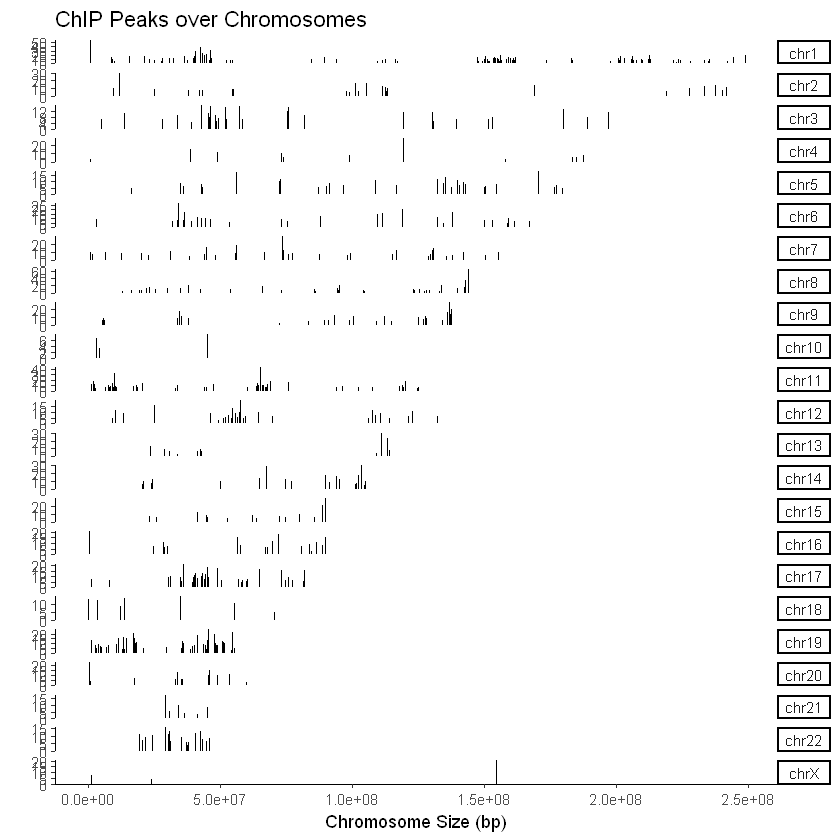

In [7]:
## plot peaks
covplot(peak, weightCol="peakscore")

In [8]:
## promoter analysis
promoter <- getPromoters(TxDb=txdb, upstream=5000, downstream=5000)
tagMatrix <- getTagMatrix(peak, windows=promoter)

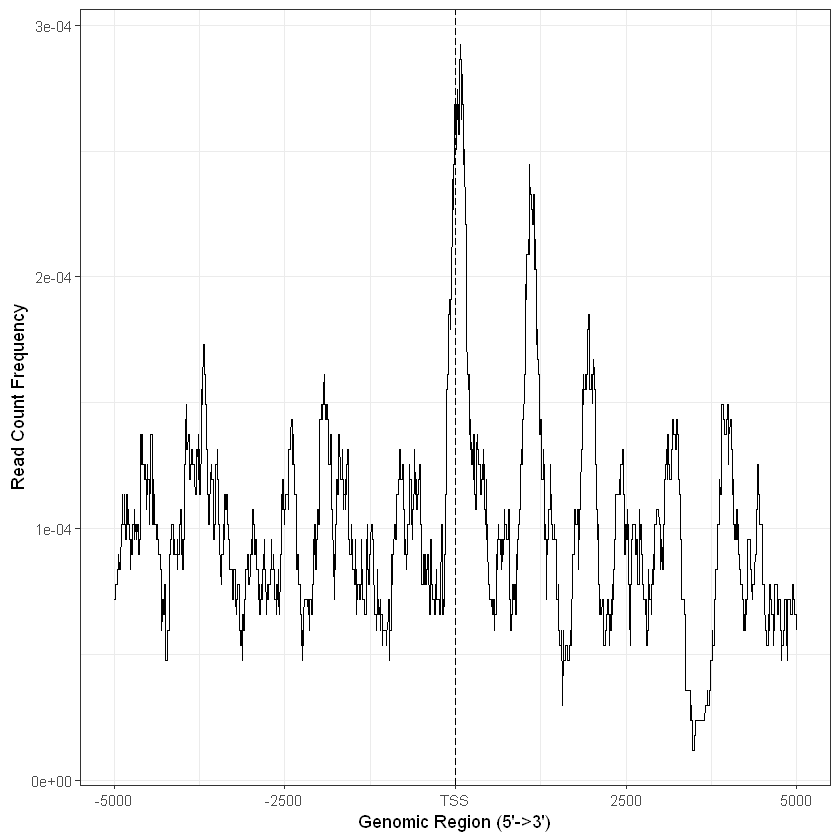

In [9]:
## plo average distances from TSS
plotAvgProf(tagMatrix, xlim=c(-5000, 5000),  xlab="Genomic Region (5'->3')", ylab = "Read Count Frequency")

In [10]:
## annotation of the peaks
peakAnno <- annotatePeak(peak, tssRegion=c(-5000, 5000),TxDb=txdb, annoDb="org.Hs.eg.db")

>> preparing features information...		 2020-11-17 10:13:31 
>> identifying nearest features...		 2020-11-17 10:13:33 
>> calculating distance from peak to TSS...	 2020-11-17 10:13:34 
>> assigning genomic annotation...		 2020-11-17 10:13:34 
>> adding gene annotation...			 2020-11-17 10:14:26 


'select()' returned 1:many mapping between keys and columns


>> assigning chromosome lengths			 2020-11-17 10:14:26 
>> done...					 2020-11-17 10:14:26 


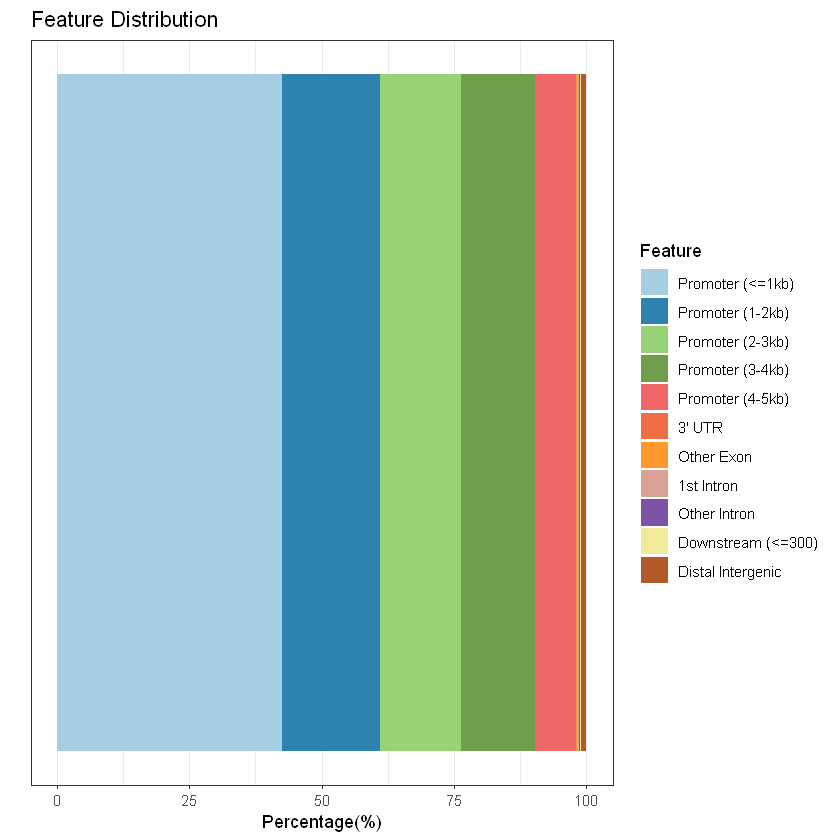

In [11]:
## plot annotations
plotAnnoBar(peakAnno)

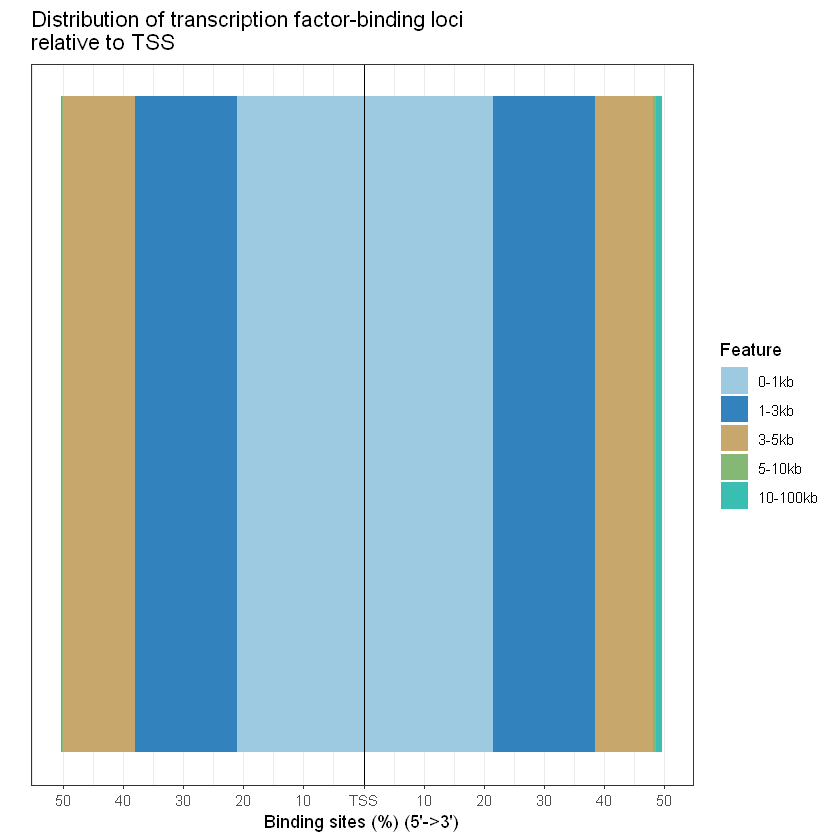

In [12]:
## plot distances to TSS
plotDistToTSS(peakAnno,title="Distribution of transcription factor-binding loci\nrelative to TSS")

In [13]:
## import limma results of COVID-19 lung transcriptome
lung<-read.table("DEG.txt",header=TRUE)
dim(lung)

[1] 21797     6

In [16]:
## preprocess lung data

lung$name<-row.names(lung)

lung%>%filter(adj.P.Val <=0.07)%>% arrange(desc(logFC))->corrected

corrected%>%mutate(neglogp=-log(P.Value,10))->cor
dim(cor)
head(cor)


[1] 3700    8

logFC,AveExpr,t,P.Value,adj.P.Val,B,name,neglogp
10.888505,1.3482723,7.911204,0.0002122632,0.06559407,-4.583766,FDCSP,3.673125
10.826476,0.7060616,8.120364,0.0001835461,0.06559407,-4.583705,RNASE2,3.736255
9.098283,3.1805312,3.665710,0.0104353027,0.06559407,-4.587041,CDR1,1.981495
8.855855,0.8817151,6.568064,0.0005875448,0.06559407,-4.584279,CYP19A1,3.230959
8.414262,-1.2925267,5.574672,0.0013951530,0.06559407,-4.584868,ECRP,2.855378
8.398832,1.0772018,4.727976,0.0031978648,0.06559407,-4.585605,CARD17,2.495140


In [17]:
## intercept peaks with transcriptome

intercept<-merge(cor,proximal,by="name")
dim(intercept)

[1] 66 13

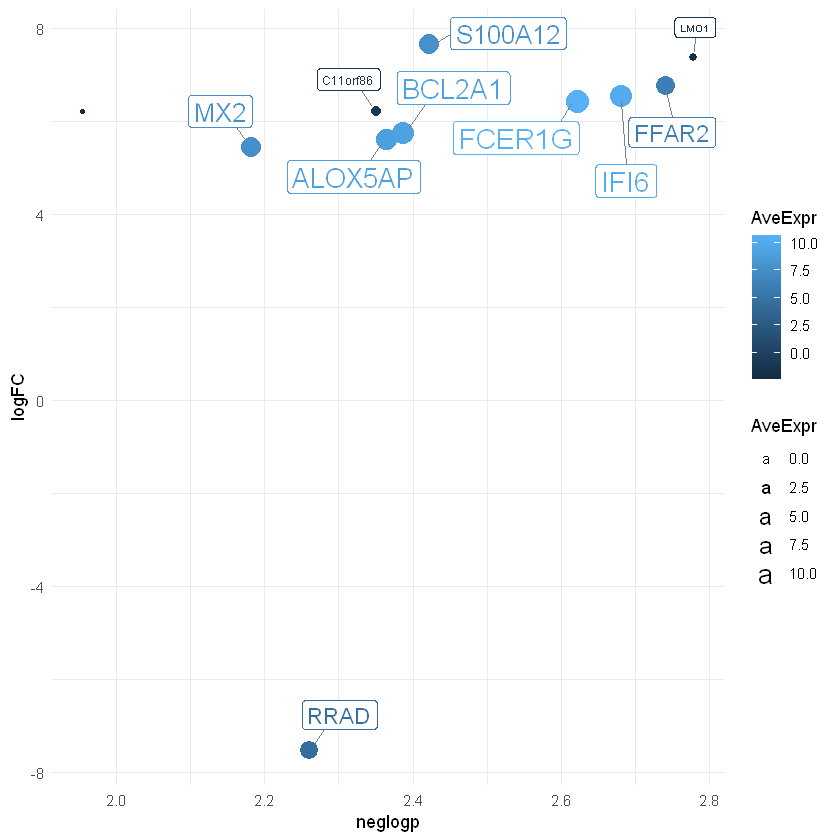

In [18]:
## plot intercept analysis between FOS ChIP and COVID-19 lung transcriptome
p=ggplot(intercept,aes(neglogp,logFC,size=AveExpr, color=AveExpr))+geom_point()+theme_minimal()
p+geom_label_repel(data= subset(intercept, neglogp>=2),aes(label = name),box.padding = 0.35,point.padding = 0.5,segment.color = 'grey50')

#### Conclusion: FOS transcription factor induced a transcriptional program in COVID-19 lung monocytes comprising inflammatory molecules (S100A12, MX2, IFI6), lipid metabolism (ALOX5AP, FFAR2), transcription factor LMO1, apototic regulator BCL2A1 and immune molecule FCER1G part of IgE receptor.